# Projet DATA BITCOIN

Lien des données : https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data?resource=download

# Sommaire

## I. Importation des données
### a. Les bibliothèques
### b. La base de données


## II. Analyse statistiques
### 1. Analyse graphiques
### 2. Analyse statistiques

## III. Prédiction


## III. Conclusion 


## I. Importation des données

### a. Les bibliothèques

In [1]:
# Importation bibliothèque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import missingno as msno


from scipy import stats
from scipy.stats import boxcox
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

### b. La base de données

In [2]:
# Importation fichier

df = pd.read_csv('btcusd_1-min_data.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [3]:
# Contrôle du fichier
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7045648 entries, 0 to 7045647
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 322.5 MB


Timestamp    0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Volume       0.0
dtype: float64


Text(0.5, 1.0, 'Graphique de représentation des valeurs manquantes')

<Figure size 1600x1000 with 0 Axes>

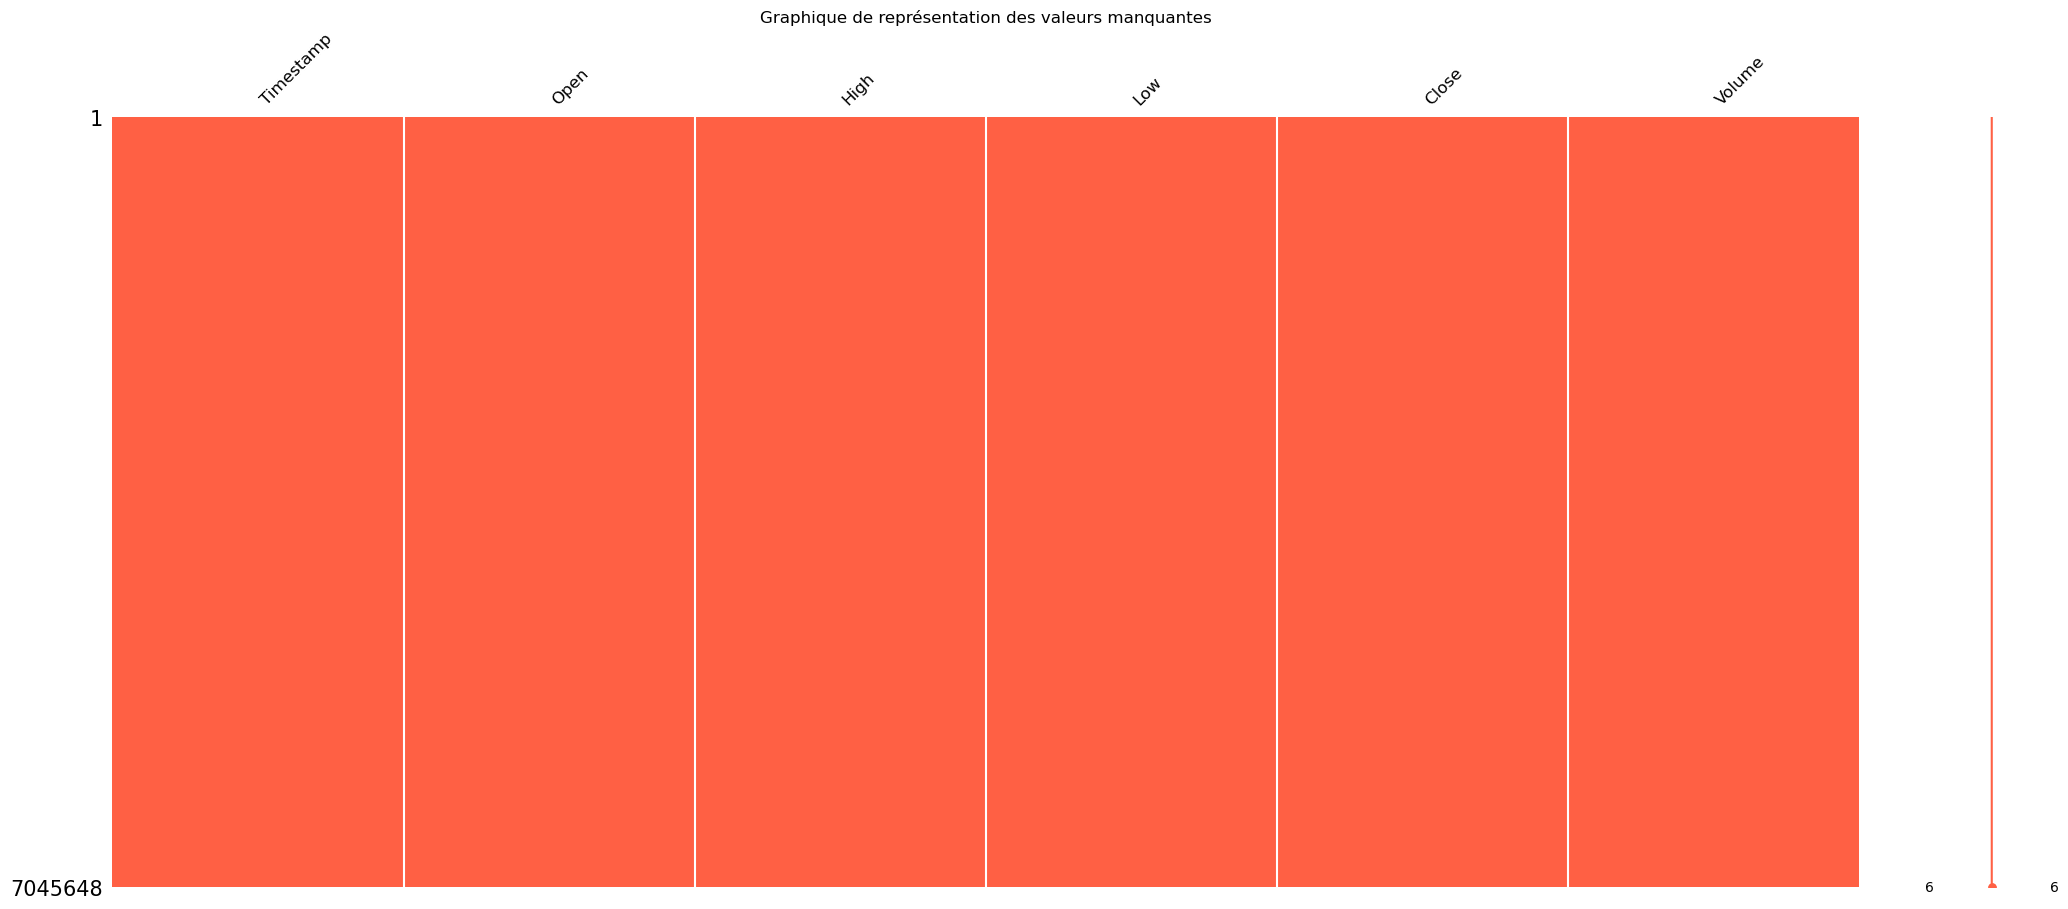

In [4]:
# Contrôle valeurs manquantes

print(df.isnull().mean()*100)

# Analyse des valeurs manquantes

plt.figure(figsize = (16,10))
msno.matrix(df, fontsize=12, color=(1, 0.38, 0.27))
plt.title('Graphique de représentation des valeurs manquantes')

Nous pouvons constater que notre fichier ne contient aucune valeur manquante, nous allons à présent démarrer notre analyse statistique.

## II. Analyse statistiques

### 1. Analyse graphiques

In [12]:
# S'assurer que Timestamp est en datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extraire l'année dans une nouvelle colonne
df['Year'] = df['Timestamp'].dt.year

# Calcul des stats par année
stats_yearly = df.groupby('Year')['Close'].agg(['mean', 'min', 'max']).reset_index()

# Calcul des variations par rapport à N-1 (en %)
stats_yearly['mean_var_%'] = stats_yearly['mean'].pct_change() * 100
stats_yearly['min_var_%'] = stats_yearly['min'].pct_change() * 100
stats_yearly['max_var_%'] = stats_yearly['max'].pct_change() * 100

# Arrondir les valeurs à 2 décimales
stats_yearly_rounded = stats_yearly.copy()
stats_yearly_rounded[['mean', 'min', 'max']] = stats_yearly_rounded[['mean', 'min', 'max']].round(2)

# Format pourcentages avec 2 décimales et ajouter le signe %
for col in ['mean_var_%', 'min_var_%', 'max_var_%']:
    stats_yearly_rounded[col] = stats_yearly_rounded[col].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "-")

stats_yearly_rounded

,Year,mean,min,max,mean_var_%,min_var_%,max_var_%
0,2012,8.23,4.32,14.22,-,-,-
1,2013,187.03,13.10,1132.96,2172.42%,203.62%,7867.92%
2,2014,525.77,312.62,935.91,181.11%,2285.91%,-17.39%
3,2015,272.19,198.48,462.70,-48.23%,-36.51%,-50.56%
4,2016,565.56,371.51,969.59,107.78%,87.18%,109.55%
5,2017,3941.62,777.04,19221.22,596.94%,109.16%,1882.41%
6,2018,7530.37,3181.18,16661.01,91.05%,309.39%,-13.32%
7,2019,7350.82,3367.63,12747.55,-2.38%,5.86%,-23.49%
8,2020,11062.74,5063.84,28833.37,50.50%,50.37%,126.19%
9,2021,47376.46,29238.81,67375.51,328.25%,477.40%,133.67%


📊 Analyse de l’évolution annuelle des cours de clôture

Cette analyse retrace l'évolution des cours de clôture moyens, minimaux et maximaux par année, ainsi que leur variation par rapport à l’année précédente :

🔹 Croissance exceptionnelle en 2013 (+2172% en moyenne), marquant le début d'une forte dynamique haussière.
🔹 Forte volatilité sur certaines années comme 2017 ou 2021, avec des hausses respectives de +597% et +328% sur les moyennes annuelles.
🔹 Des corrections notables en 2015 (-48%) et 2022 (-40%) traduisent des phases de consolidation après de fortes hausses.
🔹 L’année 2024 se démarque avec une hausse moyenne de +128%, poursuivie par un nouveau sommet en 2025 à +42%, confirmant une reprise marquée.

📈 Cette évolution témoigne d’un marché en forte croissance sur la dernière décennie, malgré quelques cycles de baisse. Les pics et replis successifs illustrent bien l’alternance entre phases spéculatives et ajustements du marché.

In [5]:
# Conversion du timestamp Unix en datetime
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Remise à l'échelle en fréquence quotidienne
df.index = df.Timestamp
df = df.resample('D').mean()

# Remise à l'échelle en fréquence mensuelle
df_month = df.resample('M').mean()

# Remise à l'échelle en fréquence annuelle (fin d'année en décembre)
df_year = df.resample('A-DEC').mean()

# Remise à l'échelle en fréquence trimestrielle (fin d'année en décembre)
df_Q = df.resample('Q-DEC').mean()

In [6]:
# Première date :
print('La première date du fichier est : ', df['Timestamp'].min())
# Dernière date
print('La première date du fichier est : ', df['Timestamp'].max())

La première date du fichier est :  2012-01-01 17:00:00
La première date du fichier est :  2025-05-26 00:24:00


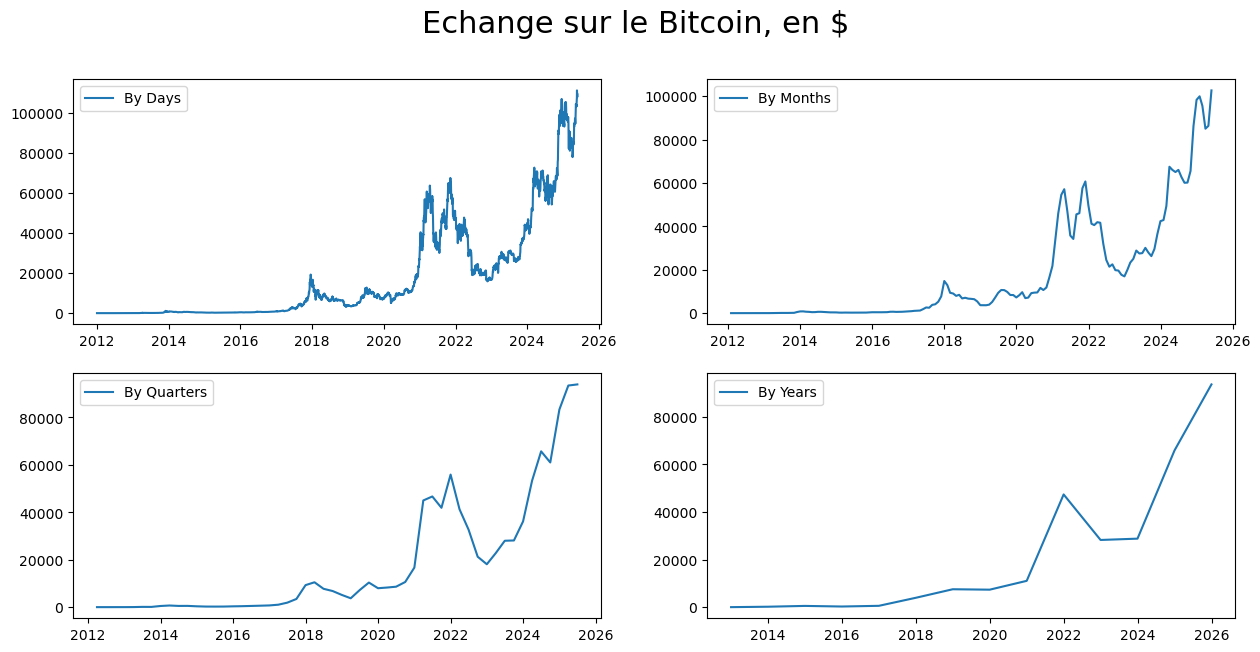

In [7]:
# Représentation graphique clôture

fig = plt.figure(figsize=[15, 7])
plt.suptitle('Echange sur le Bitcoin, en $', fontsize=22)

plt.subplot(221)
plt.plot(df['Close'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month['Close'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q['Close'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year['Close'], '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

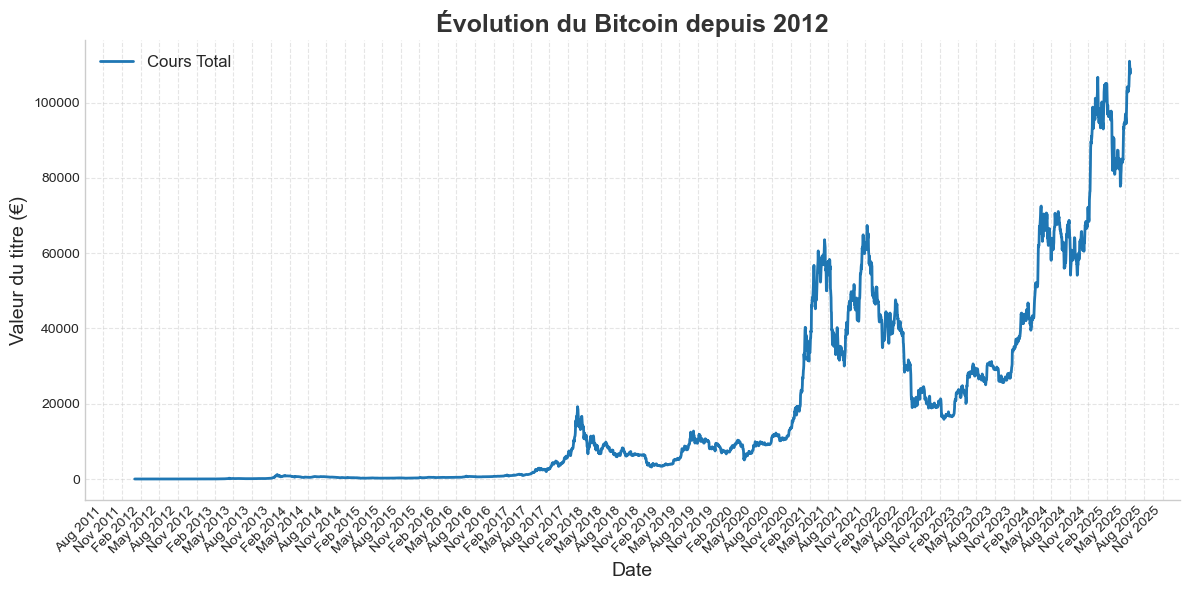

In [8]:
# Style général
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Configuration du graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer la courbe
ax.plot(df['Timestamp'], df['Close'], 
        color='#1f77b4', 
        linestyle='-', 
        linewidth=2, 
        markersize=6, 
        label='Cours Total')

# Titre et étiquettes
ax.set_title("Évolution du Bitcoin depuis 2012", fontsize=18, fontweight='bold', color='#333')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Valeur du titre (€)', fontsize=14)

# Axe X : affichage tous les 3 mois pour aérer les dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45, ha='right')

# Suppression des bordures inutiles
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Grille subtile
ax.grid(True, linestyle='--', alpha=0.5)

# Légende
ax.legend(loc='upper left', fontsize=12)

# Optimisation de l'affichage
plt.tight_layout()
plt.show()

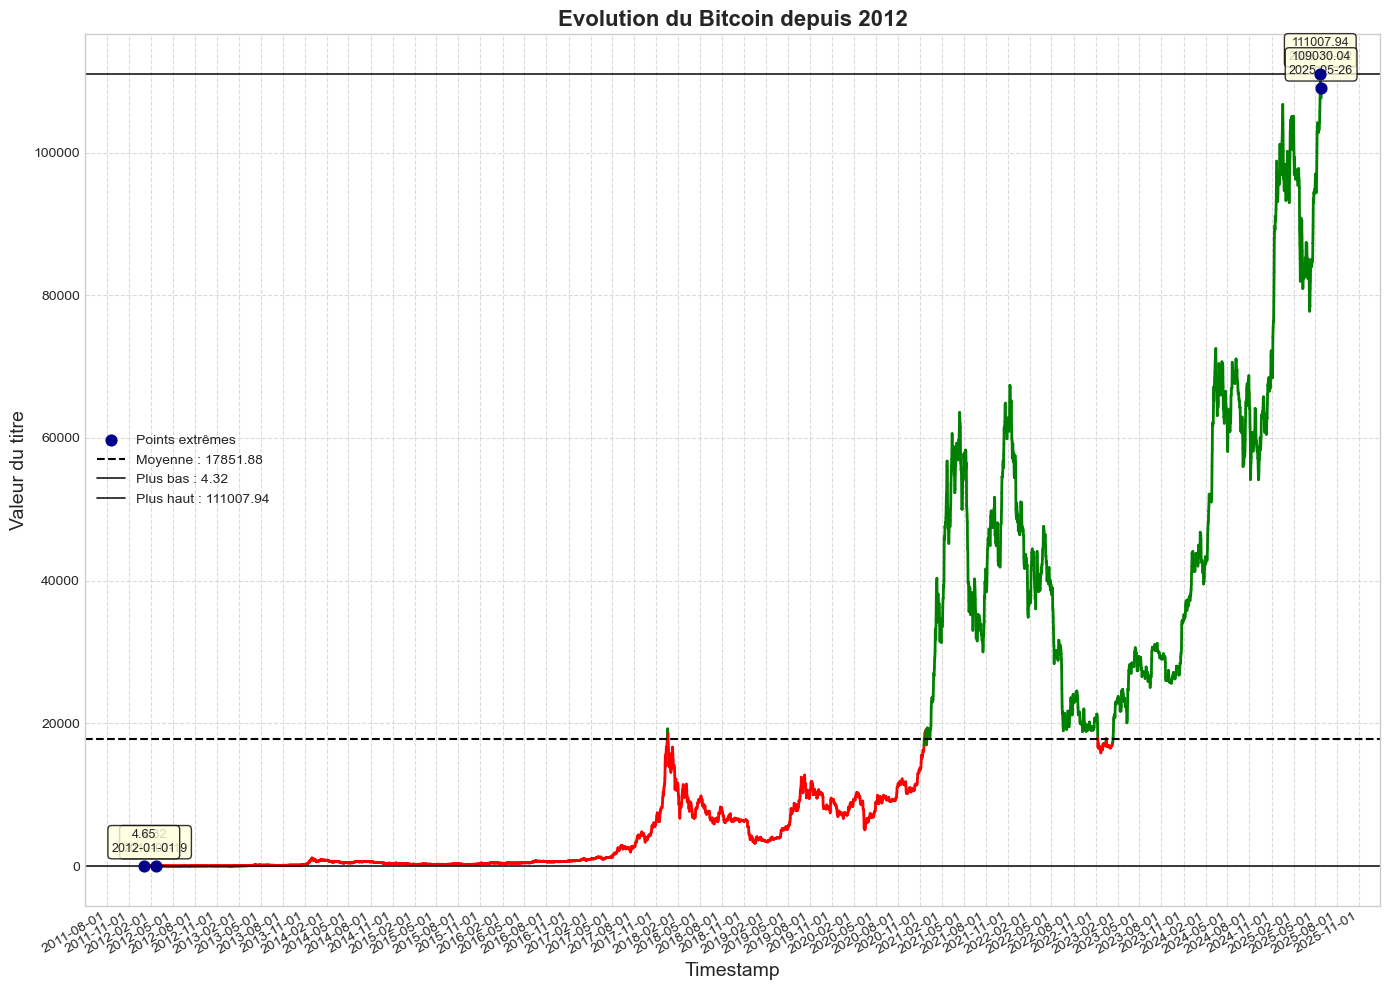

In [9]:
# Calcul de la moyenne
mean_value = df['Close'].mean()
min_value = df['Close'].min()
max_value = df['Close'].max()

# Graphique
plt.figure(figsize=(14, 10))

# Tracer des segments colorés selon la moyenne
for i in range(1, len(df)):
    color = 'green' if df['Close'].iloc[i] > mean_value else 'red'
    plt.plot(df['Timestamp'].iloc[i-1:i+1], df['Close'].iloc[i-1:i+1], color=color, linewidth=2)

# Repérer les points extrêmes
extreme_points = df.loc[[df['Close'].idxmax(), df['Close'].idxmin()], :]
# Ajouter premier et dernier
extreme_points = pd.concat([
    extreme_points,
    df.iloc[[0, -1]]
]).drop_duplicates()

# Afficher les points extrêmes
plt.scatter(extreme_points['Timestamp'], extreme_points['Close'], 
            color='darkblue', marker='o', s=60, zorder=5, label="Points extrêmes")

# Ajouter une étiquette sur chaque point extrême
for idx, row in extreme_points.iterrows():
    plt.annotate(f"{row['Close']:.2f}\n{row['Timestamp'].strftime('%Y-%m-%d')}",
                 (row['Timestamp'], row['Close']),
                 textcoords="offset points",
                 xytext=(0,10),  # Décalage vertical
                 ha='center',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='lightyellow', ec='black', alpha=0.8))

# Ligne de moyenne
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1.5, label=f"Moyenne : {mean_value:.2f}")

# Ligne du plus bas
plt.axhline(min_value, color='black', linestyle='-', linewidth=1.2, alpha=0.9, label=f"Plus bas : {min_value:.2f}")

# Ligne du plus haut
plt.axhline(max_value, color='black', linestyle='-', linewidth=1.2, alpha=0.9, label=f"Plus haut : {max_value:.2f}")

# Titre et axes
plt.title("Evolution du Bitcoin depuis 2012", fontsize=16, fontweight='bold')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Valeur du titre', fontsize=14)

# Espace date propre : 1 point tous les 3 mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30, ha='right')

# Grille + Légende
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Affichage
plt.show()

### 2. Analyse statistiques

=== Statistiques descriptives ===
count      4895.000000
mean      17851.883444
std       24775.966405
min           4.315465
25%         427.122611
50%        6675.893146
75%       27716.797569
max      111007.937500
Name: Close, dtype: float64

Asymétrie (Skewness) : 1.635
Aplatissement (Kurtosis) : 1.977

=== Test de normalité ===
Shapiro-Wilk : Stat=0.744, p-value=0.000
=> La distribution n'est pas normale.

=== Autocorrélation sur une période ===
Autocorrélation (lag 1) : 1.000

=== Statistiques sur les rendements ===
count    4894.000000
mean        0.002678
std         0.034837
min        -0.480971
25%        -0.010040
50%         0.001461
75%         0.015503
max         0.429224
Name: Rendement, dtype: float64
Jarque-Bera Test: Stat=90008.717, p-value=0.000


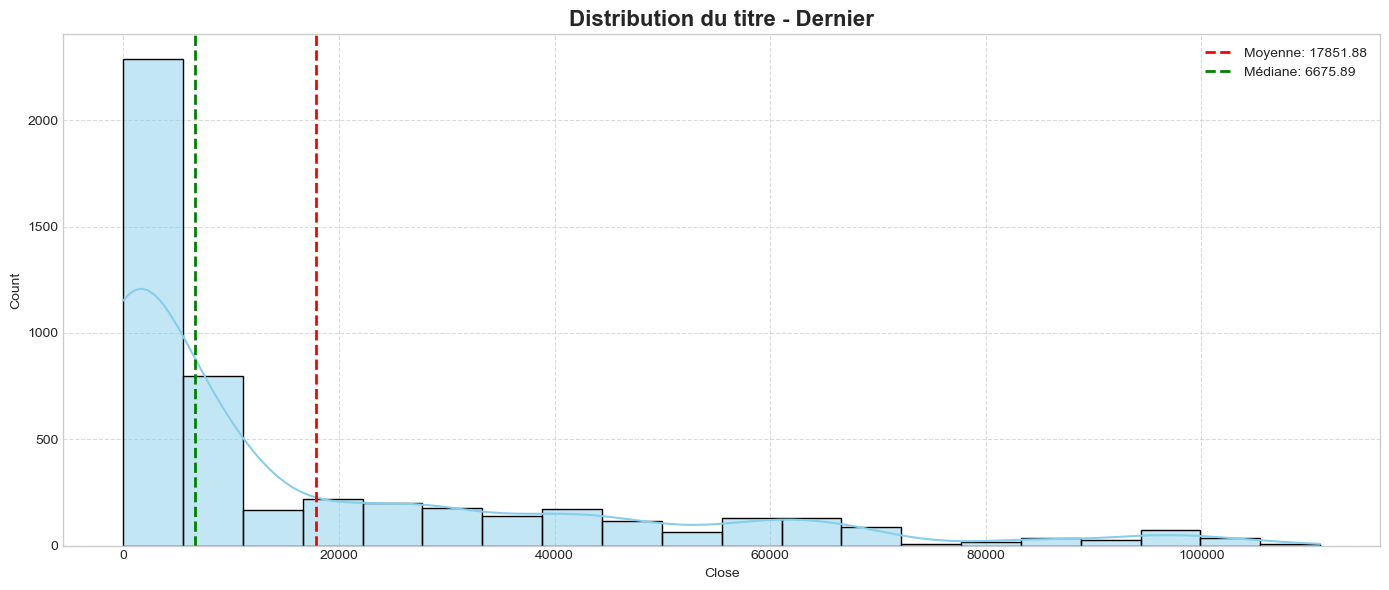

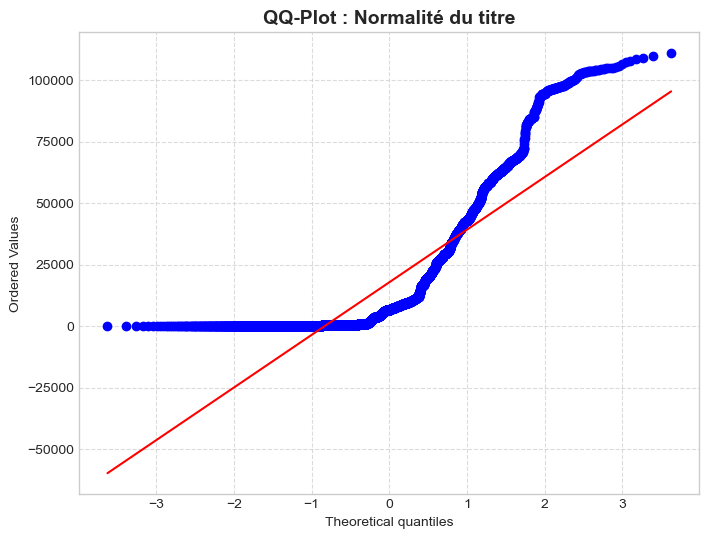


=== Analyse de tendance linéaire ===
Coefficient directeur : 13.9624
R² : 0.6343
p-value : 0.0000
=> Tendance significative détectée.


In [10]:

# Statistiques descriptives
print("=== Statistiques descriptives ===")
print(df['Close'].describe())

# Skewness (asymétrie) et Kurtosis (aplatissement)
skewness = stats.skew(df['Close'])
kurtosis = stats.kurtosis(df['Close'], fisher=True)

print(f"\nAsymétrie (Skewness) : {skewness:.3f}")
print(f"Aplatissement (Kurtosis) : {kurtosis:.3f}")

# Test de normalité
print("\n=== Test de normalité ===")
shapiro_stat, shapiro_p = stats.shapiro(df['Close'])
print(f"Shapiro-Wilk : Stat={shapiro_stat:.3f}, p-value={shapiro_p:.3f}")
if shapiro_p > 0.05:
    print("=> La distribution est compatible avec une loi normale.")
else:
    print("=> La distribution n'est pas normale.")

# Test d'autocorrélation (Durbin-Watson-like via autocorr)
print("\n=== Autocorrélation sur une période ===")
autocorr = df['Close'].autocorr(lag=1)
print(f"Autocorrélation (lag 1) : {autocorr:.3f}")

# Calcul des rendements journaliers
df['Rendement'] = df['Close'].pct_change()

print("\n=== Statistiques sur les rendements ===")
print(df['Rendement'].describe().dropna())

# Test Jarque-Bera sur les rendements
jb_stat, jb_p = stats.jarque_bera(df['Rendement'].dropna())
print(f"Jarque-Bera Test: Stat={jb_stat:.3f}, p-value={jb_p:.3f}")

# Graphique : Histogramme + KDE des "Dernier"
plt.figure(figsize=(14,6))
sns.histplot(df['Close'], bins=20, kde=True, color='skyblue')
plt.axvline(df['Close'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Moyenne: {df['Close'].mean():.2f}")
plt.axvline(df['Close'].median(), color='green', linestyle='dashed', linewidth=2, label=f"Médiane: {df['Close'].median():.2f}")
plt.title("Distribution du titre - Dernier", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique : QQ-Plot pour voir si la distribution suit la loi normale
plt.figure(figsize=(8,6))
stats.probplot(df['Close'], dist="norm", plot=plt)
plt.title("QQ-Plot : Normalité du titre", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Test de tendance linéaire
slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.arange(len(df)), df['Close']
)
print("\n=== Analyse de tendance linéaire ===")
print(f"Coefficient directeur : {slope:.4f}")
print(f"R² : {r_value**2:.4f}")
print(f"p-value : {p_value:.4f}")
if p_value < 0.05:
    print("=> Tendance significative détectée.")
else:
    print("=> Aucune tendance significative détectée.")



📊 Résumé de l’analyse statistique et de la tendance du titre
📈 Volatilité élevée
La valeur moyenne du titre est autour de 17 852 avec un écart-type très important (~24 776), indiquant une forte variation des prix.

⚖️ Distribution asymétrique
L’asymétrie (skewness = 1.635) montre une distribution légèrement penchée vers la droite, avec un aplatissement modéré (kurtosis = 1.977).

🚫 Distribution non normale
Le test de Shapiro-Wilk rejette la normalité (p-value < 0.001), ce qui est courant dans les données financières.

🔄 Forte autocorrélation
L’autocorrélation au lag 1 est parfaite (1.000), indiquant que les valeurs sont fortement liées dans le temps.

💹 Rendements positifs mais volatils
Les rendements moyens sont faibles mais positifs (~0.27%), avec une volatilité notable (écart-type ~3.5%). Leur distribution est aussi non normale (Jarque-Bera p-value < 0.001).

📉➡️📈 Tendance haussière claire
La pente de la tendance linéaire est significative (coef ≈ 13.96, p < 0.001) avec un R² de 0.63, confirmant une croissance globale du titre sur la période.

## II. Prédiction

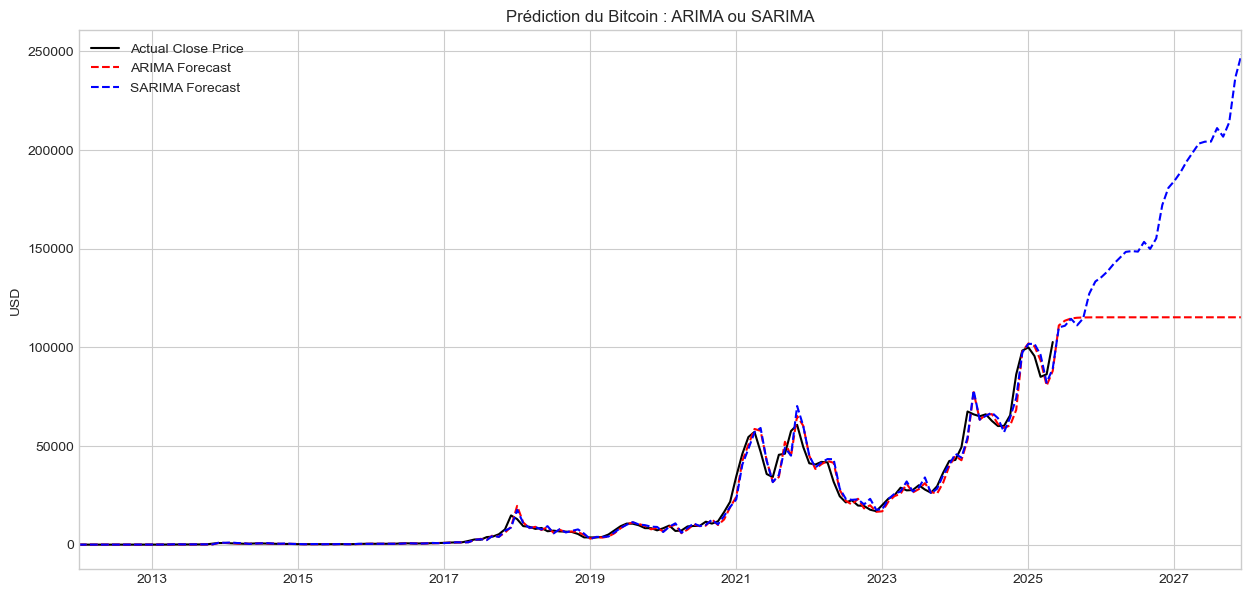

In [11]:
# 1. Transformation Box-Cox des données
df_close = df_month['Close'].dropna()
df_transformed, lmbda2 = boxcox(df_close)

# 2. Modèle ARIMA (sans composante saisonnière)
arima_model = SARIMAX(df_transformed,
                      order=(2,1,2),
                      seasonal_order=(0,0,0,0),  # Pas de saisonnalité
                      enforce_stationarity=False,
                      enforce_invertibility=False)
arima_result = arima_model.fit(disp=False)

# 3. Modèle SARIMA (avec saisonnalité annuelle)
sarima_model = SARIMAX(df_transformed,
                       order=(2,1,2),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

# 4. Génération des futures dates jusqu'à décembre 2027
last_date = df_month.index[-1]
nb_months = (2027 - last_date.year) * 12 + (12 - last_date.month)
future_dates = [last_date + relativedelta(months=i+1) for i in range(nb_months)]

# 5. Création du DataFrame de prévision
future_df = pd.DataFrame(index=future_dates, columns=['Close'])
df_pred = pd.concat([df_month[['Close']], future_df])

# 6. Prédictions ARIMA & SARIMA
forecast_arima = np.exp(np.log(lmbda2 * arima_result.predict(start=0, end=len(df_pred)-1) + 1) / lmbda2)
forecast_sarima = np.exp(np.log(lmbda2 * sarima_result.predict(start=0, end=len(df_pred)-1) + 1) / lmbda2)

# 7. Insertion dans le DataFrame
df_pred['forecast_ARIMA'] = forecast_arima
df_pred['forecast_SARIMA'] = forecast_sarima

# 8. Tracé
plt.figure(figsize=(15, 7))
df_pred['Close'].plot(label='Actual Close Price', color='black')
df_pred['forecast_ARIMA'].plot(label='ARIMA Forecast', color='red', linestyle='--')
df_pred['forecast_SARIMA'].plot(label='SARIMA Forecast', color='blue', linestyle='--')
plt.legend()
plt.title('Prédiction du Bitcoin : ARIMA ou SARIMA')
plt.ylabel('USD')
plt.grid(True)
plt.show()

On peut ici constater que les 2 modèles présentent 2 résultats différents : 

- Le modèle ARIMA indique une stagnation immédiate de l'évolution du Bitcoin.
- Le modèle SARIMA à l'inverse présente une augmentation importante de la valeur du Bitcoin dans les prochains mois.

## III. Conclusion

Ce projet a permis de réaliser une analyse approfondie de l’évolution du Bitcoin depuis 2012. Nous avons observé une longue période de stagnation durant les premières années, suivie par une explosion spectaculaire de la valeur, marquant l’entrée du Bitcoin dans une phase de forte médiatisation et de spéculation.

📊 À travers différentes analyses statistiques, nous avons mis en évidence la volatilité extrême de cet actif numérique, tant sur les rendements que sur les niveaux de prix annuels.

📈 Deux modèles de prévision ont ensuite été appliqués, permettant d’obtenir une première estimation des tendances futures, avec une décomposition saisonnière et un ajustement par transformation de variance.

⚠️ Il est important de souligner que ce travail s’inscrit dans le cadre d’un projet d’analyse de données exploratoire. Les résultats obtenus n’ont aucune vocation prédictive ou financière réelle, et ne sauraient refléter avec certitude les évolutions futures du marché des cryptomonnaies.